<h1 align="center"> Image Captioning </h1>

![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning - это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### 1. Предобработка текстов из датасета

In [ ]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

In [1]:
import numpy as np
import json
import math

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [2]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [3]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import collections
word_counts = collections.Counter()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Podsyp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
for c in captions:
    for sentence in c:
        for word in word_tokenize(sentence):
            word_counts[word.lower()] += 1

In [5]:
word2index = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2}
index2word = {0: '<SOS>', 1: '<EOS>', 2: '<PAD>'}
text = []
i = 3
length = []
max_len = 20

for c in captions:
    caption_tmp = []
    for sentence in c:
        sentence_tmp = []
        l = 1
        sentence_tmp.append(word2index['<SOS>'])
        for word in word_tokenize(sentence):
            if word_counts[word.lower()] > 5 and l < max_len-1:
                if word.lower() in word2index:
                    sentence_tmp.append(word2index[word.lower()])
                    l += 1
                else:
                    word2index[word.lower()] = i
                    index2word[i] = word.lower()
                    sentence_tmp.append(i)
                    i += 1
                    l += 1
        sentence_tmp.append(word2index['<EOS>'])
        if len(sentence_tmp) < max_len:
            while len(sentence_tmp) != max_len:
                sentence_tmp.append(word2index['<PAD>'])
        length.append(len(sentence_tmp))
        caption_tmp.append(sentence_tmp)
    text.append(caption_tmp)

In [6]:
captions[0]

['people shopping in an open market for vegetables .',
 'an open market full of people and piles of vegetables .',
 'people are shopping at an open air produce market .',
 'large piles of carrots and potatoes at a crowded outdoor market .',
 'people shop for vegetables like carrots and potatoes at an open air market .']

In [7]:
text[0]

[[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [0, 6, 7, 8, 12, 13, 3, 14, 15, 13, 10, 11, 1, 2, 2, 2, 2, 2, 2, 2],
 [0, 3, 16, 4, 17, 6, 7, 18, 19, 8, 11, 1, 2, 2, 2, 2, 2, 2, 2, 2],
 [0, 20, 15, 13, 21, 14, 22, 17, 23, 24, 25, 8, 11, 1, 2, 2, 2, 2, 2, 2],
 [0, 3, 26, 9, 10, 27, 21, 14, 22, 17, 6, 7, 18, 8, 11, 1, 2, 2, 2, 2]]

In [8]:
max(length), set(length)

(20, {20})

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.inception import Inception3
from warnings import warn
from torch.utils.model_zoo import load_url

from sklearn.model_selection import train_test_split

In [10]:
class Dataloader:
    def __init__(self, images, targets):
        self.data = list(zip(images, targets))

    def next_batch(self, batch_size, device):
        indices = np.random.randint(len(self.data), size=batch_size)

        input = [self.data[i] for i in indices]

        source = [line[0] for line in input]
        target = [self.target_random(line[1]) for line in input]

        return self.torch_batch(source, target, device)
    
    @staticmethod
    def target_random(target):
        y_index = np.random.randint(len(target), size=1)[0]
        return target[y_index]

    @staticmethod
    def torch_batch(source, target, device):
        return tuple(
            [
                torch.tensor(val, dtype=torch.float).to(device, non_blocking=True)
                for val in [source, target]
            ]
        )

In [11]:
dl = Dataloader(img_codes, text)

In [12]:
batch_size = 128

In [13]:
dl.next_batch(batch_size, 'cpu')[0].shape, dl.next_batch(batch_size, 'cpu')[1].shape

(torch.Size([128, 2048]), torch.Size([128, 20]))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(img_codes, text, test_size=0.2, random_state=42)

In [15]:
len(X_train), len(y_train)

(94629, 94629)

In [16]:
total_step = math.ceil(len(X_train) / batch_size)

In [17]:
dl_train = Dataloader(X_train, y_train)
dl_test = Dataloader(X_test, y_test)

### 2. CNN для получения эмбеддингов картинки

In [18]:
class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: 
            warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x

In [19]:
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

### 3. RNN для вывода описаний

In [20]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
vocab_size = len(word2index)

### пробовал делать линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки, но результат был гораздо хуже

In [23]:
from torch.nn.utils.rnn import pack_padded_sequence

class CaptionNet(nn.Module):
    def __init__(self, cnn_feature_size, hidden_size, vocab_size, num_layers=2):
        super(self.__class__, self).__init__()

        
        # define the properties
        self.embed_size = cnn_feature_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.embedding_layer = nn.Embedding(self.vocab_size, self.embed_size)
        
        self.lstm = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc_out_1 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc_out_2 = nn.Linear(hidden_size * 2, vocab_size)
        self.dropout = nn.Dropout(0.4)
        
        self.init_weights()
    
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """
        
        embeddings = self.embedding_layer(captions_ix)
        embeddings = torch.cat((image_vectors.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(embeddings)
        outputs = F.leaky_relu(self.dropout(self.fc_out_1(hiddens)))
        outputs = self.fc_out_2(outputs)
    
        return outputs, _
    
    def init_weights(self):
        """Initialize weights."""
        self.embedding_layer.weight.data.uniform_(-0.1, 0.1)
        self.fc_out_1.weight.data.uniform_(-0.1, 0.1)
        self.fc_out_1.bias.data.fill_(0)
        self.fc_out_2.weight.data.uniform_(-0.1, 0.1)
        self.fc_out_2.bias.data.fill_(0)

In [24]:
network = CaptionNet(cnn_feature_size=2048, hidden_size=256, vocab_size=vocab_size, num_layers=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=2)

In [25]:
def compute_loss(network, image_vectors, captions_ix, device, criterion):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    logits = network(image_vectors, captions_ix[:, :-1].type(torch.LongTensor).to(device))
    loss = criterion(logits[0].view(-1, vocab_size), captions_ix.contiguous().view(-1).type(torch.LongTensor).to(device))
    
    return loss

In [26]:
optimizer = torch.optim.Adam(network.parameters()) # favourite one

## Train it

Пишем цикл тренировки

In [27]:
max_epochs = 20

In [28]:
vocab_size

9430

In [29]:
from tqdm.notebook import trange, tqdm
import sys
from torch.optim.lr_scheduler import StepLR, ExponentialLR

losses = list()
val_losses = list()
#total_step = 100
CLIP = 0.9

for epoch in range(1, max_epochs+1):
    
    for i_step in range(1, total_step+1):
#         try:

        # set encoder into train mode
        network.train()

        # zero the gradients
        network.zero_grad()

        features, captions = dl_train.next_batch(batch_size, device)
        features, captions = features.to(device), captions.to(device)

        loss = compute_loss(network, features, captions, device, criterion)

        # Backward pass
        loss.backward()

        torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=CLIP)

        # Update the parameters in the optimizer
        optimizer.step()

        # set the evaluation mode
        network.eval()

        with torch.no_grad():

            features, captions = dl_test.next_batch(batch_size, device)
            features, captions = features.to(device), captions.to(device)

            val_loss = compute_loss(network, features, captions, device, criterion)


        # append the validation loss and training loss
        val_losses.append(val_loss.item())
        losses.append(loss.item())

        # save the losses
        np.save('losses', np.array(losses))
        np.save('val_losses', np.array(val_losses))

        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Val Loss: %.4f' % (epoch, max_epochs, i_step, total_step, loss.item(), val_loss.item())

        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
            
#         except:
#             pass
        
    # Save the weights.
#     if epoch % save_every == 0:
#         print("\nSaving the model")
#         torch.save(network.state_dict(), os.path.join('./models', 'encoder-%d.pth' % epoch))


Epoch [20/20], Step [740/740], Loss: 2.1292, Val Loss: 2.2345

## Inseption и получение результатов


In [30]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
inception = beheaded_inception_v3().train(False)

c:\users\podsyp\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\inception.py:75: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


### Сгенерируем описание

In [31]:
import random
def get_top_n(n_iter):
    if n_iter < 4:
        return 4
    elif n_iter < 7:
        return 2
    else:
        return 1

def generate_caption(image, caption_prefix=('<SOS>',), 
                     t=1, sample=True, max_len=15):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            caption_ix = torch.tensor([word2index[i] for i in caption_prefix]).view(1, -1)
            logits, hidden = network(vectors_neck.cuda(), caption_ix.cuda())
            probability = F.softmax(logits.cpu(), 2)[0, -1, :]
            
            nn = get_top_n(_)
            
            topv, topi = probability.data.topk(nn)
            value = random.randint(0, nn-1)
            if index2word[topi[value].item()] == '<EOS>':
                break
            caption_prefix.append(index2word[topi[value].item()])
            
            
    return caption_prefix

# Demo

In [49]:
from matplotlib import pyplot as plt
#from scipy.misc import imresize
#from PIL.Image import resize as imresize
from PIL import Image


#%matplotlib inlinep

#sample image
#!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
#img = imresize(img, (299, 299)).astype('float32') / 255.
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

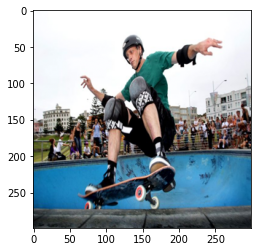

In [50]:
plt.imshow(img)

In [51]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a young boy on a skateboard doing a trick
a skateboarder doing a jump on the edge of a ramp
the skateboarder does n't do n't is in the air
the skateboarder rides a skateboard on a ramp
the person jumps over a ramp on a skateboard
man doing trick on a skateboard in a skate park
man riding a skateboard down a rail
man in black jacket doing tricks on skateboard
the skateboarder does not look to hit the ramp
the man is jumping in mid air while riding a skateboard


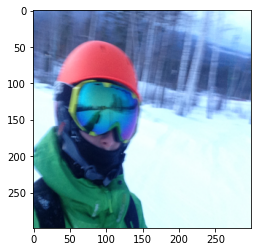

the person on the snowboard is going down the hill
there s no picture here to the side of the mountain
a person riding a snow board down a snow covered slope
there are a couple on the snow with a
an old woman standing in a snow covered area
there is two snowboarders that is skiing down the
an old photo with a person skiing down a snowy hill
a man on snow ski in the snow
an adult in a red jacket and a red
a skier in black jacket standing in the snow


In [48]:
img = plt.imread('img2.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

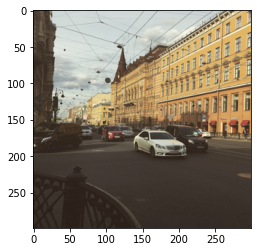

cars driving past the street with a car on the side
a bus parked in a parking lot with a car on the side of
the street has a car and a car on the street
an empty street in a busy street with a car and a bus
the car rides through a street at night
a city with a lot of people on
an orange and yellow bus driving down a street
cars parked next to a car on a street
a bus is driving down the road with a car on the side
an orange truck is parked at the curb of a street


In [59]:
img = plt.imread('img3.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

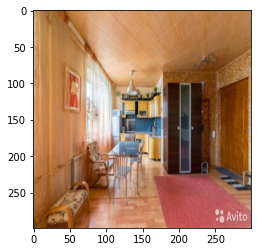

this kitchen is clean , and ready for us to use
an empty kitchen is decorated in a large room
a large room that is very large and clean
the view to the window of the living room
an image of two couches in the middle of a
this kitchen and house is empty and ready to use
an open couch and a table in a room
this is an apartment with an empty living room
this living area has a couch and a table
the living area shows the dining room and a living room


In [44]:
img = plt.imread('img4.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

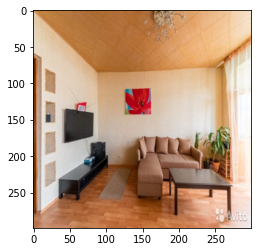

a room that includes two beds , a table , and a television
a room filled with a large bed and a television
an old living table with two chairs and a table
this kitchen and couch are empty and the living room is clean
this is the view of a room with a couch and a television
the room is decorated in the room with a couch
an empty living area has two couches and a television
this is a living area with a couch and a television
an open room filled with furniture , a table , and a television
the bedroom features white furniture , a couch , and a television


In [38]:
img = plt.imread('img5.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

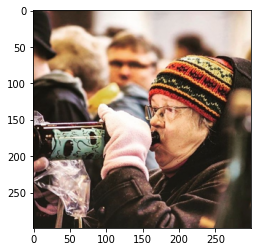

a man with glasses is talking on a cell phone
the person in a red shirt has a cell phone
there 's an elephant that is sitting on the
there s no picture to look like a man
a young girl is holding up a cell phone
two young women sitting in front of a cell phone
there are three men that have a cell phone
the man in red is holding a cell phone
the young woman smiles as he talks on her cell phone
there is an older woman sitting in a chair with a cell


In [39]:
img = plt.imread('img6.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

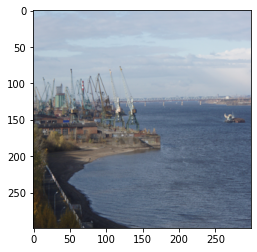

several people standing in a body boat in the water
there are people that is standing in the sand
a bunch of water that are on a beach
several boats are docked in a large body of water
a bunch or water sitting on top of a beach
the water was on a beach of a beach
a group of boats sitting in a field
the view of the ocean and a body of water
the water was on a beach of a beach
the view from an ocean in a field with a boat


In [40]:
img = plt.imread('img7.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

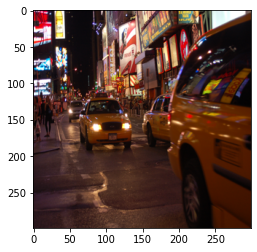

the car drives along a city street
the city bus has been changed for a parking meter
an image on street with a car parked on the
an empty city street with cars and cars
an image shot shows a car stop
a car is stopped at a stop light
two red cars are parked on the side of the street
the street signs is empty at night
two parking meters are on the side of the street
a parking meters on a city sidewalk with a car on the side


In [52]:
img = plt.imread('img8.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

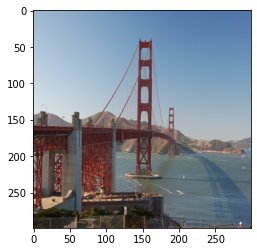

an old train on a bridge over a river
an image on an empty bridge over a
the boat on the water has a clock on it
an empty bench in front a large body of water
an image on train tracks with a clock tower
the large ben tower has a clock on it
a bridge over the water with a clock tower
there 's no back station with the sun shining on it
a bridge in front of the water with a clock tower
the boat sits at a train yard with a clock tower


In [42]:
img = plt.imread('img9.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

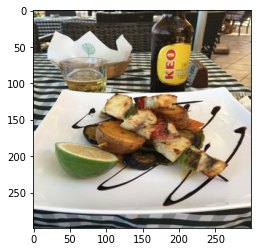

two pieces with food on a white plate
a table that is filled for the meal
a plate filled with food and a cup of coffee
two pieces and food with some food on a plate
two pieces on a plate on a table with a sandwich
two sandwiches on the cob and a cup of coffee
there are a table with a plate of food on
a plate that is holding some food on it
a table filled that is covered with a sandwich and a cup of coffee
there 's an assortment if food on a plate


In [54]:
img = plt.imread('img10.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

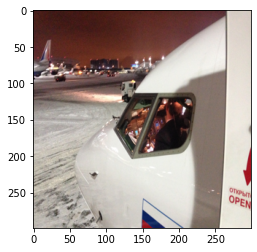

two people in an airport waiting for a train
two small airplanes parked on the runway at a airport
the reflection up a rear mirror of a car
the man has the rear view of a large white airplane
a white and black airplane on the runway
an orange car with an advertisement in the rear view mirror
a man sitting on a car with a suitcase
a large white and blue plane on a runway
the man is waiting to board a large red airplane
two small passenger trains are on a runway


In [58]:
img = plt.imread('img11.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

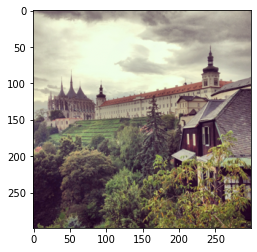

a large tower that is on top of a building
a clock on top a city road with a clock tower
a clock on an old brick tower with a clock on it
the clock tower in front of a building
there 's no image to a city street with a clock tower
the clock is standing in the middle of the city
an image shot with an old building with a clock tower
an old building is in front of a building
a tall brick tower in the middle of a city
an image shot shows the top end of a building with a clock tower


In [57]:
img = plt.imread('img12.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

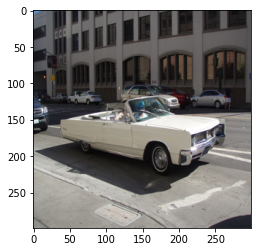

an old car with a red license door
a car with an open car parked in front of it
the two bags show the contents of the car
the two bags show the same cars are on the street
an orange cat sits on a car seat
an open bag is on the ground with a suitcase
the back seat view of an old car and a car
a black cat sitting in front of a car
an image is a car parked on the
a large black motorcycle parked in front of a building


In [62]:
img = plt.imread('img13.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

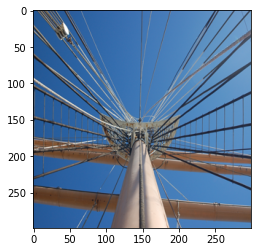

the clock has been on a building
the sun is lit up at night
there is two clocks on the side of a
the clock is built up the ceiling of the building
there is an old building with a clock on
a tall clock tower is shown in front of a building
there is two umbrellas that are in the
there are several different colored umbrellas on the
the large building has a large tower with a clock on it
a large red clock on a post in front of a building


In [65]:
img = plt.imread('img14.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

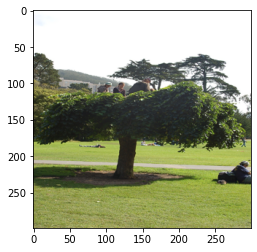

a group of people standing on a beach next to a large boat
two cows walking across a lush green field
an elephant walking in the grass near a body of water
the man and two children are sitting on a bench
the two people in a park with a boat and a boat
a group if people are standing in a field with a boat
two men standing in a field near a boat
a couple on the back of an elephant in the water
the man in a suit and tie is standing on a boat
two men are standing in a park with a boat


In [68]:
img = plt.imread('img15.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

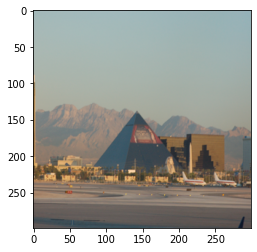

an image is in the distance in front of a building
an image if a group of horses standing in the grass
a group if animals standing on a dirt road
an old photo with a horse standing in the middle of a field
the horse stands on a hill in the middle of a field
the two horses are grazing in a field
two animals standing next to a building in the middle of a forest
the two horses graze in the grass in the middle of a field
a horse is standing in the grass near a fence
two sheep standing in the middle or a road


In [75]:
img = plt.imread('img16.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

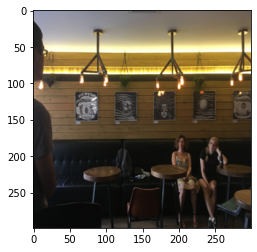

an open living area filled of furniture
an open dining table filled with a lot of books
a man and girl are sitting in a room with a clock
an image of two people standing in a
there s some people sitting at a table with a
a group and people sitting around tables with a clock
a table with some chairs and a
there are people that is standing around a
the people in the room is a table with a clock
an old living lot has a lot of chairs and a table


In [77]:
img = plt.imread('img17.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

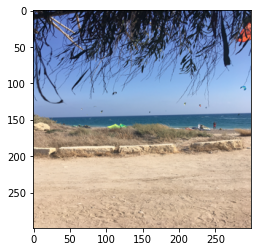

the person in black is flying up over the beach
two kites fly through the sky over a body of water
the people on a field flying kites on the beach
a couple is walking on a sandy beach
the person flies a large parachute on a beach
a group if men flying a kite on a beach
two people on some sand flying kites on a beach
people in water , with a parachute flying over the ocean
the people in a field of kites are flying in the sky
two birds standing in a field with a sky


In [79]:
img = plt.imread('img18.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

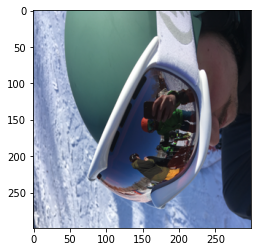

a person taking pictures of an old style plane
a black and black bird is standing on a toilet
an orange cat laying on a wooden floor
an animal sits inside of a toilet
the reflection in front of a mirror with a blue and white cat
the cat 's face is on a toilet
an animal sitting in a car seat with a knife
the reflection of the reflection in a mirror
there are two small cats sitting on a toilet
an old cat is sitting in a car


In [80]:
img = plt.imread('img19.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

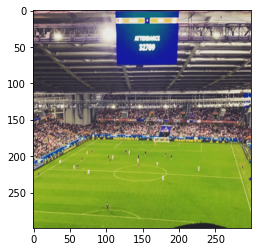

two people playing tennis on a tennis court
there are two players on the tennis
the person in white shirt and blue shorts is playing tennis
two women in a white tennis court playing tennis
two people playing doubles on a court with a tennis racket
a woman is playing a tennis game on a court
the man jumps to return a ball on the court
there 's the man is playing a game of
two men are on a tennis match with rackets
a man on his tennis racket on a court


In [83]:
img = plt.imread('img20.jpg')
img = np.array(Image.fromarray(img).resize((299,299))) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))